In [ ]:
#| default_exp main

### imports

In [ ]:
#| export
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from transformers import logging
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from tqdm.auto import tqdm
from torch import autocast
from PIL import Image
from matplotlib import pyplot as plt
import numpy
from torchvision import transforms as tfms

# For video display:
from IPython.display import HTML
from base64 import b64encode
import pandas as pd

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

from transformers import CLIPVisionModel,CLIPProcessor

from mytools import tools as mt
from PIL import Image
import numpy as np

import pandas as pd

In [ ]:
#| export
def select_cuda():
    import  py3nvml.py3nvml as nvidia_smi

    nvidia_smi.nvmlInit()

    deviceCount = nvidia_smi.nvmlDeviceGetCount()
    dfs =[]
    for i in range(deviceCount):
        handle = nvidia_smi.nvmlDeviceGetHandleByIndex(i)
        info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
        dfs.append( pd.DataFrame([i, 100*info.free/info.total],
                 index = ['device', 'free']).T)
    devices = pd.concat(dfs).astype('int64').set_index('device')
    nvidia_smi.nvmlShutdown()

    return devices[devices['free']==devices['free'].max()].index[0]

In [ ]:
#| export
from functools import partial
from PIL import Image, ImageOps

# Set device
torch_device = select_cuda()

# Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

### init

In [ ]:
#| export
batch_size = 1

height = 32                        # default height of Stable Diffusion
width = 32                         # default width of Stable Diffusion
num_inference_steps = 53            # Number of denoising steps
guidance_scale = 7.5                # Scale for classifier-free guidance
generator = torch.manual_seed(3)    # Seed generator to create the inital latent noise

###
1 text to emb
2 img to latents
3 emb and lats to img

In [ ]:
#| export
def text2vector(prompt,negative_prompt = ""):
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
        [negative_prompt] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
    return torch.cat([uncond_embeddings, text_embeddings])

In [ ]:
#| export
def random_latents(seed=3):
    generator = torch.manual_seed(seed)
    # Prep Scheduler
    scheduler.set_timesteps(num_inference_steps)

    # Prep latents
    latents = torch.randn(
      (batch_size, unet.in_channels, height // 8, width // 8),
      generator=generator,
    )
    latents = latents.to(torch_device)
    return latents * scheduler.init_noise_sigma # Scaling (previous versions did latents = latents * self.scheduler.sigmas[0]

In [ ]:
#| export
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [ ]:
#| export
def latents_to_pil(latents):
    latents = 1 / 0.18215 * latents
    with torch.no_grad():
        image = vae.decode(latents).sample

    # Display
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    return [Image.fromarray(image) for image in images]

In [ ]:
#| export
def img2latents(img,start_step):
    encoded = pil_to_latent(img)
    start_sigma = scheduler.sigmas[start_step]
    noise = torch.randn_like(encoded)
    latents = scheduler.add_noise(encoded, noise, timesteps=torch.tensor([scheduler.timesteps[start_step]]))
    return latents.to(torch_device).float()

In [ ]:
#| export
def loop(text_embeddings,latents,start_step=0,guidance_scale=7.5,nograd = True):
    start_step =start_step-1
    with autocast("cuda"):
        for i, t in tqdm(enumerate(scheduler.timesteps)):
            if i > start_step: # << This is the only modification to the loop we do
                # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
                latent_model_input = torch.cat([latents] * 2)
                sigma = scheduler.sigmas[i]
                # Scale the latents (preconditioning):
                # latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5) # Diffusers 0.3 and below
                latent_model_input = scheduler.scale_model_input(latent_model_input, t)

                # predict the noise residual
                
                
                
                if nograd:
                    with torch.no_grad():
                        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
                        
                else:
                    noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
                    

                # perform guidance
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

                # compute the previous noisy sample x_t -> x_t-1
                # latents = scheduler.step(noise_pred, i, latents)["prev_sample"] # Diffusers 0.3 and below
                latents = scheduler.step(noise_pred, t, latents).prev_sample       
    return latents

In [ ]:
import torch.optim as optim

In [ ]:
from IPython.display import clear_output

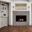

In [ ]:
Y_img = Image.open('Y.png').resize((height,width));Y_img

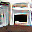

In [ ]:
Y_lat = pil_to_latent(Y_img)
latents_to_pil(Y_lat)[0]

In [ ]:
text_embeddings = text2vector('fireplace')

In [ ]:
Y_hat = random_latents(234234)
Y_hat.requires_grad= True

In [ ]:
def criterion(y_pred, y):
    return torch.mean((y_pred - y) ** 2)

In [ ]:
learning_rate = 0.1

In [ ]:
while True:
    unet.zero_grad()
    Y_hat_lat = loop(text_embeddings,Y_hat,nograd = False)
    clear_output()
    display(latents_to_pil(Y_hat_lat)[0])
    loss = criterion(Y_hat_lat,Y_lat)
    display(loss)
    [g]  = torch.autograd.grad(loss, [Y_hat])
    Y_hat.data -= learning_rate * len(Y_hat) * g

In [ ]:
!nbdev_export